In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(train_data,test_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_plot = test_data[['date','spot_price','rho','v0']].copy()
    test_plot = test_plot.reset_index().set_index('date')
    test_plot['MAE'] = test_diff.resample('D').apply(compute_RMSE)
    test_plot['RMSE'] = test_diff.resample('D').apply(compute_RMSE)
    test_plot = test_plot.reset_index()
    test_plot = test_plot.drop_duplicates(subset=['date'],keep='last').set_index('date').drop(columns='calculation_date')
    
    train_plot = train_data[['date','spot_price','rho','v0']].copy()
    train_plot = train_plot.reset_index().set_index('date')
    train_plot['MAE'] = train_diff.resample('D').apply(compute_RMSE)
    train_plot['RMSE'] = train_diff.resample('D').apply(compute_RMSE)
    train_plot = train_plot.reset_index()
    train_plot = train_plot.drop_duplicates(subset=['date'],keep='last').set_index('date').drop(columns='calculation_date')
    trainx = pd.date_range(start=min(train_data.index),end=max(train_data.index),periods=train_plot.shape[0])
    train_plot.index = trainx

    
    testx = pd.date_range(start=min(test_data.index),end=max(test_data.index),periods=test_plot.shape[0])
    test_plot.index = testx
    
    
    fig,axs = plt.subplots(max(len(train_plot.columns),len(test_plot.columns)),figsize=(10,10),sharex=True)
    for i,col in enumerate(train_plot.columns):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(test_plot.columns):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if f.find('Legacy')==-1])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 024203778497 cboe spx relative barrier


In [4]:
selected_model = models.iloc[0]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'seed': 1312,
 'raw_data':          spot_price  strike_price  barrier  days_to_maturity updown outin  \
 0            2576.0        2318.4   1288.0                60   Down   Out   
 1            2576.0        2318.4   1288.0                60   Down   Out   
 2            2576.0        2318.4   1288.0                60   Down    In   
 3            2576.0        2318.4   1288.0                60   Down    In   
 4            2576.0        2318.4   1288.0                90   Down   Out   
 ...             ...           ...      ...               ...    ...   ...   
 2142715      5857.0        6442.7   8785.5               540     Up    In   
 2142716      5857.0        6442.7   8785.5               720     Up   Out   
 2142717      5857.0        6442.7   8785.5               720     Up   Out   
 2142718      5857.0        6442.7   8785.5               720     Up    In   
 2142719      5857.0        6442.7   8785.5               720     Up    In   
 
             w barrier_type_name  r

In [5]:
model['train_data']

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,...,date,barrier_price,relative_spot,relative_barrier_price,relative_barrier,relative_rebate,relative_observed,insample_target,insample_prediction,insample_error
0,2576.0,2318.400,1288.0000,60,Down,Out,call,DownOut,0.0,0.019360,...,2017-11-16,2.619162e+02,1.111111,1.095377e-01,0.555556,0.0,1.095377e-01,1.095377e-01,0.111199,1.661479e-03
1449,2576.0,2511.600,2601.7600,180,Up,Out,put,UpOut,0.0,0.019360,...,2017-11-16,2.037687e+01,1.025641,8.174880e-03,1.035897,0.0,8.174880e-03,8.174880e-03,0.001913,-6.262110e-03
1448,2576.0,2511.600,2601.7600,180,Up,Out,call,UpOut,0.0,0.019360,...,2017-11-16,9.055459e-01,1.025641,3.634210e-04,1.035897,0.0,3.634210e-04,3.634210e-04,0.002506,2.142239e-03
1447,2576.0,2511.600,2601.7600,90,Up,In,put,UpIn,0.0,0.019360,...,2017-11-16,1.913444e+01,1.025641,7.633000e-03,1.035897,0.0,7.633000e-03,7.633000e-03,0.027197,1.956368e-02
1446,2576.0,2511.600,2601.7600,90,Up,In,call,UpIn,0.0,0.019360,...,2017-11-16,9.395820e+01,1.025641,3.700910e-02,1.035897,0.0,3.700910e-02,3.700910e-02,0.033295,-3.714343e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273051,2767.0,2974.525,2061.4150,60,Down,In,put,DownIn,0.0,0.018894,...,2018-10-11,1.480799e+03,0.930233,4.963244e-01,0.693023,0.0,4.963244e-01,4.963244e-01,0.481384,-1.494029e-02
273049,2767.0,2974.525,2061.4150,60,Down,Out,put,DownOut,0.0,0.018894,...,2018-10-11,3.475816e-20,0.930233,1.184061e-23,0.693023,0.0,1.184061e-23,1.184061e-23,0.000000,-1.184061e-23
273047,2767.0,2974.525,1722.4575,720,Down,In,put,DownIn,0.0,0.018894,...,2018-10-11,1.411523e+03,0.930233,4.814074e-01,0.579070,0.0,4.814074e-01,4.814074e-01,0.505964,2.455636e-02
273063,2767.0,2974.525,2061.4150,360,Down,In,put,DownIn,0.0,0.018894,...,2018-10-11,1.448898e+03,0.930233,4.854901e-01,0.693023,0.0,4.854901e-01,4.854901e-01,0.497392,1.190193e-02


In [6]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

dividend rate: 
0      0.012624
1      0.012628
2      0.012641
3      0.012671
4      0.012687
         ...   
580    0.021949
581    0.022022
582    0.022742
583    0.022894
584    0.023780
Name: dividend_rate, Length: 585, dtype: float64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
483    0.054494
484    0.054500
485    0.054513
486    0.054801
487    0.054889
Name: risk_free_rate, Length: 488, dtype: float64

theta: 
0      8.181674e-11
1      4.564269e-10
2      4.968155e-10
3      2.185459e-09
4      2.286232e-09
           ...     
860    1.418934e+00
861    1.518398e+00
862    1.732709e+00
863    1.836051e+00
864    1.869788e+00
Name: theta, Length: 865, dtype: float64

kappa: 
0      3.553361e-10
1      2.253735e-09
2      2.648255e-09
3      3.573693e-09
4      6.275163e-09
           ...     
860  

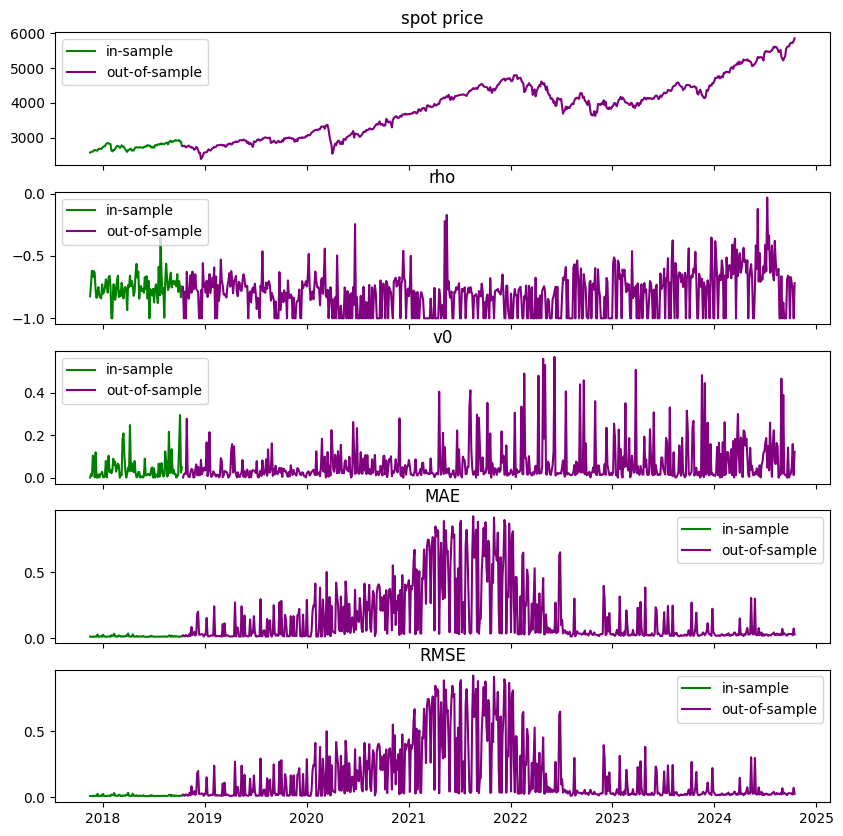

['days_to_maturity', 'dividend_rate', 'risk_free_rate', 'theta', 'kappa', 'rho', 'eta', 'v0', 'relative_spot', 'relative_barrier', 'relative_rebate', 'w', 'barrier_type_name']


In [8]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
plot_errors(train_data,test_data)
print(model['feature_set'])

# retraining

In [9]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [10]:
retraining_frequency = 30 #days
test_dates = model['test_dates']
full_dataset = model['dataset']
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates

0     2017-11-16
1     2017-11-17
2     2017-11-22
3     2017-11-28
4     2017-11-29
         ...    
743   2024-09-24
744   2024-10-07
745   2024-10-08
746   2024-10-09
747   2024-10-14
Name: date, Length: 748, dtype: datetime64[ns]

In [11]:
retraining_dates = len(test_dates)//retraining_frequency
retraining_dates = test_dates.iloc[np.linspace(0,len(test_dates)-1,retraining_dates,dtype=int)]
retraining_dates = retraining_dates.reset_index(drop=True)

def retrain(date):
    development_dates = all_dates[all_dates<=date]
    subset_test_dates = all_dates[~all_dates.isin(development_dates)].iloc[:retraining_frequency]
    retrainer = convsklearn()
    retrainer.excluded_features += model['excluded_features']
    retrainer.target_name = model['target_name']
    retrainer.load_data(full_dataset)
    retrainer.preprocess_data(development_dates, subset_test_dates,plot=False)
    retrainer.run_dnn(print_details=False)
    retrainer.test_prediction_accuracy()
    print(date)
    return (date,retrainer)

from joblib import Parallel, delayed
models = Parallel()(delayed(retrain)(d) for d in retraining_dates)


in sample:
     RMSE: 0.013948707376607387
     MAE: 0.008351881129919171

out of sample:
     RMSE: 0.0846781968569097
     MAE: 0.03679471203151676
2018-10-15 00:00:00


E:\Python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")

KeyboardInterrupt



In [ ]:
stop yo

In [ ]:
retraining_dates = [d for d in models.keys()]
cols = ['cpu','isMAE','isRMSE','osMAE','osRMSE']
df = pd.DataFrame(np.tile(np.nan,(len(retraining_dates),len(cols))),columns=cols,index=retraining_dates)

for i,row in df.iterrows():
    m = models[i]
    df.at[i,'cpu'] = m['dnn_runtime']
    df.at[i,'isMAE'] = compute_MAE(m['train_data']['insample_error'])
    df.at[i,'isRMSE'] = compute_RMSE(m['train_data']['insample_error'])
    df.at[i,'osMAE'] = compute_MAE(m['test_data']['outofsample_error'])
    df.at[i,'osRMSE'] = compute_RMSE(m['test_data']['outofsample_error'])


print(df)

In [ ]:
from plotters import PlotCols
PlotCols(df)